## **Importing necessary modules**

In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
from datetime import datetime
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score

from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
from keras.layers import RNN, SimpleRNN
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

<br/>

## **Connected with google drive**

In [3]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


<br/>

## **Getting the data**
We are using **Google stock price** dataset.  
Source: [Kaggle]('https://www.kaggle.com/')

In [4]:
df = pd.read_csv('drive/My Drive/Datasets/Google_Stock_Price_Train.csv')
test_df = pd.read_csv('drive/My Drive/Datasets/Google_Stock_Price_Test.csv')

<br/>

## **Reconnaissance**

In [5]:
df.head()

,Date,Open,High,Low,Close,Volume
0,26-Sep-17,936.69,944.08,935.12,937.43,1672749
1,25-Sep-17,939.45,939.75,924.51,934.28,1873375
2,22-Sep-17,942.77,950.00,940.84,943.26,1074806
3,21-Sep-17,948.13,952.80,939.38,947.55,1370685
4,20-Sep-17,937.73,950.00,937.50,947.54,2004018


In [6]:
test_df.head()

,Date,Open,High,Low,Close,Volume
0,25-Oct-17,986.27,994.43,977.72,991.46,1395282
1,24-Oct-17,986.50,989.26,977.08,988.49,1445129
2,23-Oct-17,1005.18,1005.79,983.10,985.54,1639294
3,20-Oct-17,1007.05,1008.65,1002.27,1005.07,1606031
4,19-Oct-17,1004.75,1007.32,997.30,1001.84,1714243


In [7]:
df.shape

(1258, 6)

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1258 entries, 0 to 1257
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    1258 non-null   object 
 1   Open    1258 non-null   float64
 2   High    1258 non-null   float64
 3   Low     1258 non-null   float64
 4   Close   1258 non-null   float64
 5   Volume  1258 non-null   int64  
dtypes: float64(4), int64(1), object(1)
memory usage: 59.1+ KB


<br/>

# **Feature Engineering**

<br/>
<br/>

## **Converting the data type of 'Data' into datetime object**

In [9]:
df['Date'] = pd.to_datetime(df['Date'])

In [10]:
df.dtypes

Date      datetime64[ns]
Open             float64
High             float64
Low              float64
Close            float64
Volume             int64
dtype: object

<br/>

## **Ordering the 'Date' feature**

In [11]:
df = df.sort_values(by = ['Date'], ascending = True).reset_index()

In [12]:
df.head()

,index,Date,Open,High,Low,Close,Volume
0,1257,2012-09-26,375.30,381.00,370.87,377.11,5674334
1,1256,2012-09-27,380.35,381.80,376.20,378.63,3932272
2,1255,2012-09-28,377.45,380.03,375.95,377.63,2784091
3,1254,2012-10-01,379.90,382.88,378.48,381.27,3168477
4,1253,2012-10-02,382.98,383.38,375.51,378.87,2790375


In [13]:
df.tail()

,index,Date,Open,High,Low,Close,Volume
1253,4,2017-09-20,937.73,950.00,937.50,947.54,2004018
1254,3,2017-09-21,948.13,952.80,939.38,947.55,1370685
1255,2,2017-09-22,942.77,950.00,940.84,943.26,1074806
1256,1,2017-09-25,939.45,939.75,924.51,934.28,1873375
1257,0,2017-09-26,936.69,944.08,935.12,937.43,1672749


<br/>
<br/>

# **Visualization**

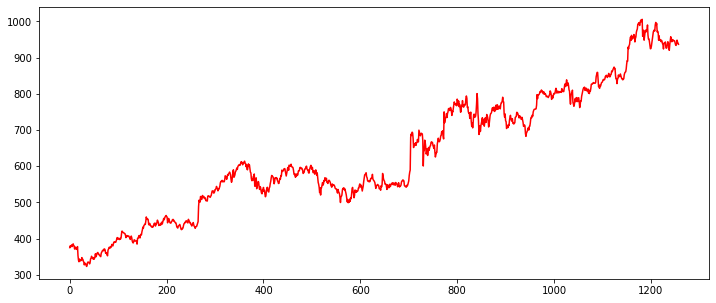

In [14]:
plt.figure(figsize= (12, 5))
df['Open'].plot(color = 'red')
plt.show()

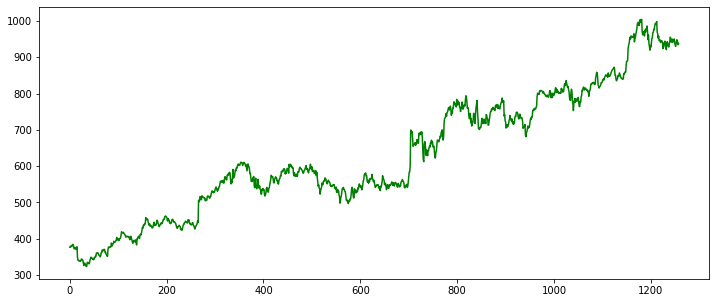

In [15]:
plt.figure(figsize= (12, 5))
df['Close'].plot(color = 'green')
plt.show()

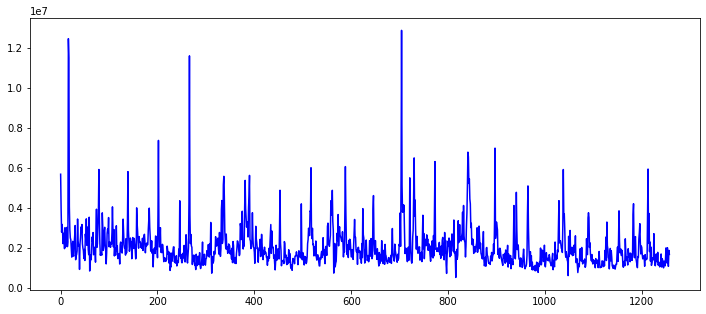

In [16]:
plt.figure(figsize= (12, 5))
df['Volume'].plot(color = 'blue')
plt.show()

<br/>
<br/>

## **Feature Selection**

In [17]:
df.columns

Index(['index', 'Date', 'Open', 'High', 'Low', 'Close', 'Volume'], dtype='object')

In [18]:
input_feature = df[['Open', 'High', 'Low', 'Volume', 'Close']]
input_data = input_feature.values

In [19]:
input_data[:5]

array([[3.753000e+02, 3.810000e+02, 3.708700e+02, 5.674334e+06,
        3.771100e+02],
       [3.803500e+02, 3.818000e+02, 3.762000e+02, 3.932272e+06,
        3.786300e+02],
       [3.774500e+02, 3.800300e+02, 3.759500e+02, 2.784091e+06,
        3.776300e+02],
       [3.799000e+02, 3.828800e+02, 3.784800e+02, 3.168477e+06,
        3.812700e+02],
       [3.829800e+02, 3.833800e+02, 3.755100e+02, 2.790375e+06,
        3.788700e+02]])

<br/>
<br/>

## **Feature Scaling**

In [20]:
scaler = MinMaxScaler(feature_range= (0, 1))
input_data[:, :] = scaler.fit_transform(input_data[:, :])

In [21]:
input_data[:5]

array([[0.07619802, 0.07945378, 0.07747309, 0.41770245, 0.07819275],
       [0.08360086, 0.08062718, 0.08533097, 0.2764961 , 0.08042683],
       [0.07934972, 0.07803104, 0.08496241, 0.18342797, 0.07895704],
       [0.0829412 , 0.08221127, 0.08869232, 0.21458516, 0.08430707],
       [0.08745621, 0.08294464, 0.08431373, 0.18393734, 0.08077958]])

In [22]:
len(df)

1258

In [23]:
lookback=50
total_size = len(df)

X=[]
y=[]

for i in range(0, total_size-lookback):
    t = []
    
    for j in range(0, lookback): # loop for 50 days
        current_index = i+j
        t.append(input_data[current_index, :]) # get data margin from 50 days with marging i
    X.append(t)
    y.append(input_data[lookback+i, 4])

In [24]:
X[0]

[array([0.07619802, 0.07945378, 0.07747309, 0.41770245, 0.07819275]),
 array([0.08360086, 0.08062718, 0.08533097, 0.2764961 , 0.08042683]),
 array([0.07934972, 0.07803104, 0.08496241, 0.18342797, 0.07895704]),
 array([0.0829412 , 0.08221127, 0.08869232, 0.21458516, 0.08430707]),
 array([0.08745621, 0.08294464, 0.08431373, 0.18393734, 0.08077958]),
 array([0.08050779, 0.08141923, 0.08574377, 0.13678355, 0.08483619]),
 array([0.0856678 , 0.08580481, 0.09105116, 0.15671199, 0.0889222 ]),
 array([0.09150212, 0.08910499, 0.09517912, 0.17967179, 0.08862825]),
 array([0.08437779, 0.08116988, 0.08717382, 0.11651816, 0.08141158]),
 array([0.08341029, 0.07951245, 0.07860829, 0.20124374, 0.07129944]),
 array([0.07033437, 0.06939189, 0.07546808, 0.12321169, 0.07163749]),
 array([0.07844086, 0.07744434, 0.08432847, 0.15099674, 0.07673766]),
 array([0.07766393, 0.07477485, 0.07975822, 0.15284484, 0.07178447]),
 array([0.07039301, 0.0666784 , 0.06988058, 0.202558  , 0.06900657]),
 array([0.06907369, 

In [25]:
y[0]

0.028131751840910046

<br/>
<br/>

## **Splitting into Train, Test and Validation set**

In [26]:
test_size = 100
validate_size = 10

X, y = np.array(X), np.array(y)


X_test = X[test_size:]
y_test = y[test_size:]


X_work = X[:test_size]
y_work = y[:test_size]


X_valid = X[:validate_size]
y_valid = y[:validate_size]
X_train = X[validate_size:]
y_train = y[validate_size:]

<br/>

#### **Shape of the Train, Test and Validation set**

In [27]:
print('Shape of X_Train set : {}'.format(X_train.shape))
print('Shape of y_Train set : {}'.format(y_train.shape))
print('Shape of X_test set : {}'.format(X_test.shape))
print('Shape of y_test set : {}'.format(y_test.shape))
print('Shape of X_valid set : {}'.format(X_valid.shape))
print('Shape of y_valid set : {}'.format(y_valid.shape))
print('Shape of X_work set : {}'.format(X_work.shape))
print('Shape of y_work set : {}'.format(y_work.shape))


Shape of X_Train set : (1198, 50, 5)
Shape of y_Train set : (1198,)
Shape of X_test set : (1108, 50, 5)
Shape of y_test set : (1108,)
Shape of X_valid set : (10, 50, 5)
Shape of y_valid set : (10,)
Shape of X_work set : (100, 50, 5)
Shape of y_work set : (100,)


<br/>

## **Reshaping**

In [28]:
X_train = X_train.reshape(X_train.shape[0], lookback, 5)
X_test = X_test.reshape(X_test.shape[0], lookback, 5)
X_valid = X_valid.reshape(X_valid.shape[0], lookback, 5)

print(X_train.shape)
print(X_valid.shape)
print(X_test.shape)

(1198, 50, 5)
(10, 50, 5)
(1108, 50, 5)


<br/>

## **RNN (LSTM) model architecture**

In [41]:
model = Sequential()

model.add(SimpleRNN(50, activation='relu', input_shape = (X.shape[1], 5), return_sequences = False))
model.add(Dense(1, activation='relu'))

<br/>

#### **Model Summary**

In [42]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_1 (SimpleRNN)     (None, 50)                2800      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 51        
Total params: 2,851
Trainable params: 2,851
Non-trainable params: 0
_________________________________________________________________


<br/>

## **Callbacks**

In [43]:
callbacks = [EarlyStopping(patience = 10, verbose = 1),
             ReduceLROnPlateau(factor = 0.1, patience = 3, min_lr = 0.00001, verbose = 1),
             ModelCheckpoint('model.h5', verbose = 1, save_best_only = True, save_weights_only= True)]

<br/>

## **Compile the model**

In [44]:
model.compile(optimizer = 'adam', loss = 'mean_squared_error', metrics = ['accuracy'])

<br/>

## **Train the model**

In [45]:
history = model.fit(X_train, y_train, epochs = 100, batch_size = 32, validation_data = (X_valid, y_valid), callbacks = callbacks)

Epoch 1/100
37/38 [============================>.] - ETA: 0s - loss: 0.1483 - accuracy: 8.4459e-04
Epoch 00001: val_loss improved from inf to 0.01085, saving model to model.h5
38/38 [==============================] - 1s 33ms/step - loss: 0.1466 - accuracy: 8.3472e-04 - val_loss: 0.0108 - val_accuracy: 0.0000e+00
Epoch 2/100
37/38 [============================>.] - ETA: 0s - loss: 0.0025 - accuracy: 8.4459e-04
Epoch 00002: val_loss improved from 0.01085 to 0.00439, saving model to model.h5
38/38 [==============================] - 1s 30ms/step - loss: 0.0025 - accuracy: 8.3472e-04 - val_loss: 0.0044 - val_accuracy: 0.0000e+00
Epoch 3/100
37/38 [============================>.] - ETA: 0s - loss: 8.6700e-04 - accuracy: 8.4459e-04
Epoch 00003: val_loss improved from 0.00439 to 0.00049, saving model to model.h5
38/38 [==============================] - 1s 30ms/step - loss: 8.8145e-04 - accuracy: 8.3472e-04 - val_loss: 4.8514e-04 - val_accuracy: 0.0000e+00
Epoch 4/100
37/38 [===================

<br/>

## **Loss vs Epochs**

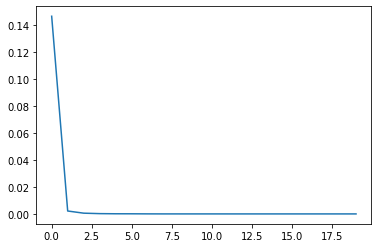

In [46]:
plt.plot(history.history['loss'])
plt.show()

<br/>

## **Prediction**

In [47]:
y_pred = model.predict(X_test)

<br/>

## **Visualize the model with the actual and predicted values**

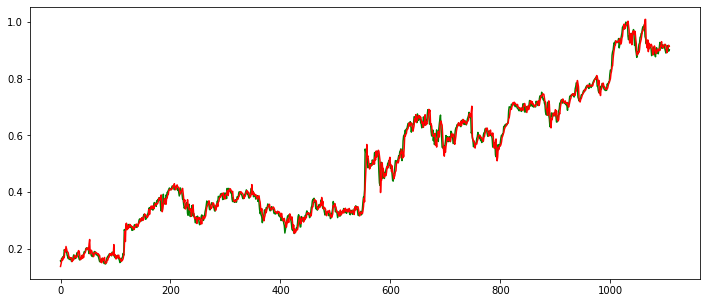

In [48]:
plt.figure(figsize = (12, 5))

plt.plot(y_test, color = 'green', label = 'Actual')
plt.plot(y_pred, color = 'red', label = 'Predicted')

plt.show()

<br/>

## **Creating a pandas DataFrame with the actual and predicted values**

In [49]:
df_result = pd.DataFrame(np.c_[y_test, y_pred], columns = ['Actual', 'Predicted'])
df_result

,Actual,Predicted
0,0.157708,0.138228
1,0.154519,0.147747
2,0.166586,0.156925
3,0.165013,0.165597
4,0.171451,0.160958
...,...,...
1103,0.916604,0.891934
1104,0.916619,0.906506
1105,0.910314,0.911233
1106,0.897115,0.917922


<br/>

## **Accuracy Score**

In [50]:
print('Accuracy Score is {}%'.format(r2_score(y_test, y_pred).round(4)*100))

Accuracy Score is 99.31%
